<a href="https://colab.research.google.com/github/abshilpa/Chronic-Kidney-Disease-Data-Science-Project/blob/main/MSC_Final_project_CKD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MSC Data Science Final Project on Chronic Kidney Disease by Abbugari Dhanalakshmi Shilpa

## Chronic Kidney Disease Prediction Overview

This project is focused on predicting chronic kidney disease (CKD) by analyzing essential medical parameters,including Specific Gravity, Hypertension, Hemoglobin, Diabetes Mellitus, Albumin, Appetite, Red Blood Cell Count, Pus Cell, and more.
By utilizing advanced machine learning models, the system delivers precise predictions to support healthcare professionals in early diagnosis and informed decision-making, ultimately enhancing patient outcomes.

## Importing Required Libraries

In [49]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_recall_curve,
                             classification_report, ConfusionMatrixDisplay, accuracy_score)
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import joblib
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score



## Data Loading and Overview

Raw Dataset of CKD :
    id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]

 CKD Dataset Info:

<class 'pandas.core.frame.D

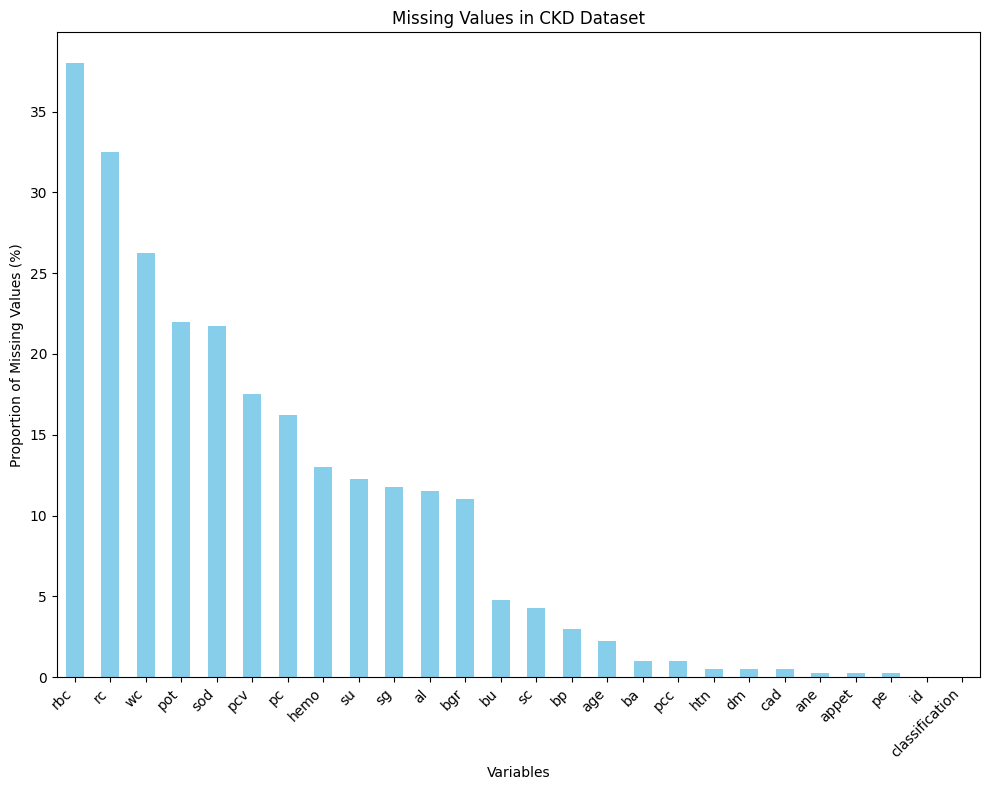

In [50]:
def load_CKDdata(file_path):
    """
    Loading the dataset and displaying basic information such as
    the few rows of dataset's, info, and missing values summary.

    Parameters:
    file_path (str): Path of the CKD Raw dataset file from Github.

    Returns:
    pd.DataFrame: Loaded CKD dataset.
    """
    CKD_data = pd.read_csv(file_path)
    print("Raw Dataset of CKD :\n", CKD_data.head())
    print("\n CKD Dataset Info:\n")
    print(CKD_data.info())
    print(CKD_data.describe())
    print("\nMissing Values in CKD data set:\n", CKD_data.isnull().sum())
    # Classifying columns : categorical columns and numerical columns
    cat_cols = [col for col in CKD_data.columns if CKD_data[col].dtype=='object']
    num_cols = [col for col in CKD_data.columns if CKD_data[col].dtype!='object']

    # Displaying the  counts and names of the columns
    print(f"Count of categorical columns: {len(cat_cols)}")
    print("Categorical columns:", cat_cols)

    print(f"\nCount of numerical columns: {len(num_cols)}")
    print("Numerical columns:", num_cols)

    return CKD_data

def plot_missing_values_bar(data):
    """
    Plotting a bar chart to visualize missing values proportion in each column.

    Parameters:
    data (pd.DataFrame): The dataset to analyze.
    """
    missing_values = (data.isna().sum() / data.shape[0] * 100).sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    missing_values.plot(kind='bar', color='skyblue')
    plt.title('Missing Values in CKD Dataset')
    plt.xlabel('Variables')
    plt.ylabel('Proportion of Missing Values (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Replace 'file_path' with the actual location of your dataset
file_path = "https://raw.githubusercontent.com/abshilpa/Chronic-Kidney-Disease-Data-Science-Project/refs/heads/main/kidney_disease.csv"
CKD_data = load_CKDdata(file_path)
plot_missing_values_bar(CKD_data)


## Data Preprocessing

In [51]:

def treat_outliers(data, numeric_cols, iqr_multiplier=1.5):
    """
    Treat outliers using the IQR method by capping extreme values to the bounds.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric columns to treat for outliers.
    iqr_multiplier (float): Multiplier for the IQR to define outlier thresholds.

    Returns:
    pd.DataFrame: Dataset with treated outliers.
    """
    data_treated = data.copy()

    print("Treating outliers...")
    for col in numeric_cols:
        Q1 = data_treated[col].quantile(0.25)
        Q3 = data_treated[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        print(f"{col}: Lower bound = {lower_bound}, Upper bound = {upper_bound}")

        # Cap outliers
        data_treated[col] = data_treated[col].clip(lower=lower_bound, upper=upper_bound)

    return data_treated

def plot_outliers(data, numeric_cols, title="Box Plot of Numeric Features"):
    """
    Plot box plots for numeric features.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric column names.
    title (str): Title for the plot.
    """
    num_cols = len(numeric_cols)
    rows = (num_cols // 3) + (num_cols % 3 > 0)

    plt.figure(figsize=(15, rows * 4))
    for idx, col in enumerate(numeric_cols):
        plt.subplot(rows, 3, idx + 1)
        sns.boxplot(y=data[col], color="skyblue")
        plt.title(f"Box Plot of {col}")
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def preprocess_data(CKD_data):
    """
    Preprocess the CKD dataset:
    - Rename columns.
    - Handle missing values.
    - Treat outliers.
    - Encode categorical variables.
    - Scale numerical features.
    - Classify columns into categorical and numerical types.

    Parameters:
    CKD_data (pd.DataFrame): The dataset to preprocess.

    Returns:
    pd.DataFrame: Preprocessed dataset.
    """
    # Step 1: Rename columns to standard names
    CKD_data.columns = [
        'ID', 'Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
        'Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
        'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Sodium',
        'Potassium', 'Hemoglobin', 'Packed Cell Volume', 'White Blood Cell Count',
        'Red Blood Cell Count', 'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
        'Appetite', 'Pedal Edema', 'Anemia', 'Classification'
    ]
    print("Updated DataFrame with new column names:")
    print(CKD_data.head())

    # Step 2: Handle non-standard values
    CKD_data.replace({'\t?': np.nan}, inplace=True)
    CKD_data['Classification'] = CKD_data['Classification'].str.replace('ckd\t', 'ckd', regex=False)
    CKD_data['Diabetes Mellitus'].replace({'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'}, inplace=True)
    CKD_data['Coronary Artery Disease'].replace({'\tno': 'no'}, inplace=True)
    print("Unique values in 'Classification' after replacement:")
    print(CKD_data['Classification'].unique())
    print("Unique values in 'Diabetes Mellitus' after replacement:")
    print(CKD_data['Diabetes Mellitus'].unique())
    print("Unique values in 'Coronary Artery Disease' after replacement:")
    print(CKD_data['Coronary Artery Disease'].unique())


    # Step 3: Handle missing values
    cat_cols = [col for col in CKD_data.columns if CKD_data[col].dtype == 'object']
    for col in cat_cols:
        CKD_data[col].fillna(CKD_data[col].mode()[0], inplace=True)

    num_cols = [col for col in CKD_data.columns if CKD_data[col].dtype in ['float64', 'int64']]
    for col in num_cols:
        CKD_data[col].fillna(CKD_data[col].median(), inplace=True)

    print("\nMissing values after cleaning:")
    print(CKD_data.isnull().sum())

    # Step 4: Plot outliers before treatment
    print("Plotting outliers before treatment...")
    plot_outliers(CKD_data, num_cols, title="Outliers Before Treatment")

    # Step 5: Treat outliers
    CKD_data = treat_outliers(CKD_data, num_cols)

    # Step 6: Plot outliers after treatment
    print("Plotting outliers after treatment...")
    plot_outliers(CKD_data, num_cols, title="Outliers After Treatment")

    # Step 7: Encode categorical variables
    for col in cat_cols:
        CKD_data[col] = LabelEncoder().fit_transform(CKD_data[col])

    # Step 8: Scale numeric features
    scaler = StandardScaler()
    CKD_data[num_cols] = scaler.fit_transform(CKD_data[num_cols])

    print("\nData after encoding and scaling:")
    print(CKD_data.head())

    return CKD_data


Updated DataFrame with new column names:
   ID   Age  Blood Pressure  Specific Gravity  Albumin  Sugar Red Blood Cells  \
0   0  48.0            80.0             1.020      1.0    0.0             NaN   
1   1   7.0            50.0             1.020      4.0    0.0             NaN   
2   2  62.0            80.0             1.010      2.0    3.0          normal   
3   3  48.0            70.0             1.005      4.0    0.0          normal   
4   4  51.0            80.0             1.010      2.0    0.0          normal   

   Pus Cell Pus Cell Clumps    Bacteria  ...  Packed Cell Volume  \
0    normal      notpresent  notpresent  ...                  44   
1    normal      notpresent  notpresent  ...                  38   
2    normal      notpresent  notpresent  ...                  31   
3  abnormal         present  notpresent  ...                  32   
4    normal      notpresent  notpresent  ...                  35   

   White Blood Cell Count  Red Blood Cell Count  Hypertension  

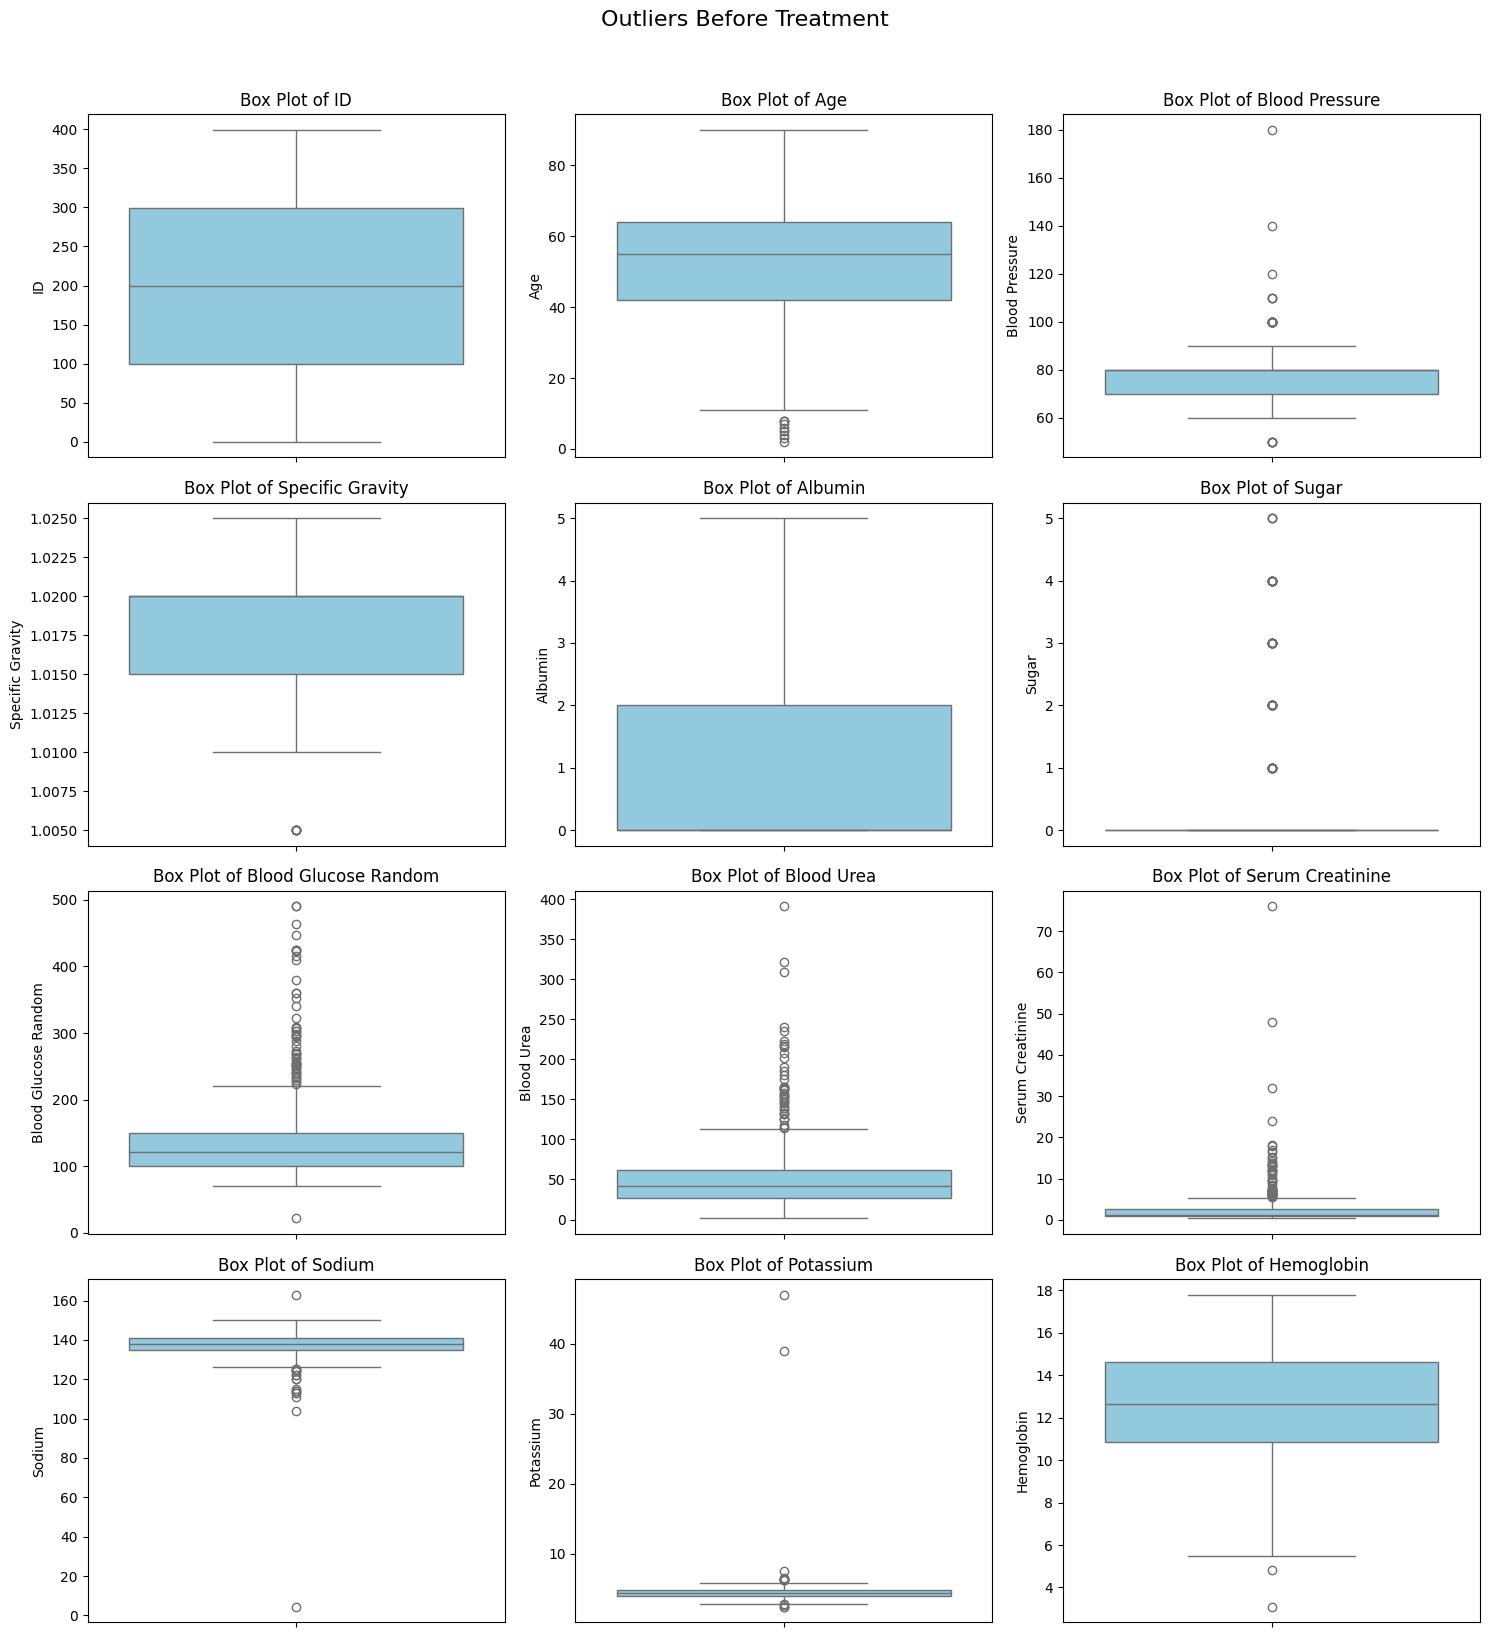

Treating outliers...
ID: Lower bound = -199.5, Upper bound = 598.5
Age: Lower bound = 9.0, Upper bound = 97.0
Blood Pressure: Lower bound = 55.0, Upper bound = 95.0
Specific Gravity: Lower bound = 1.0074999999999998, Upper bound = 1.0275000000000003
Albumin: Lower bound = -3.0, Upper bound = 5.0
Sugar: Lower bound = 0.0, Upper bound = 0.0
Blood Glucose Random: Lower bound = 27.5, Upper bound = 223.5
Blood Urea: Lower bound = -25.125, Upper bound = 113.875
Serum Creatinine: Lower bound = -1.8375000000000004, Upper bound = 5.4625
Sodium: Lower bound = 126.0, Upper bound = 150.0
Potassium: Lower bound = 2.8000000000000003, Upper bound = 6.0
Hemoglobin: Lower bound = 5.25, Upper bound = 20.25
Plotting outliers after treatment...


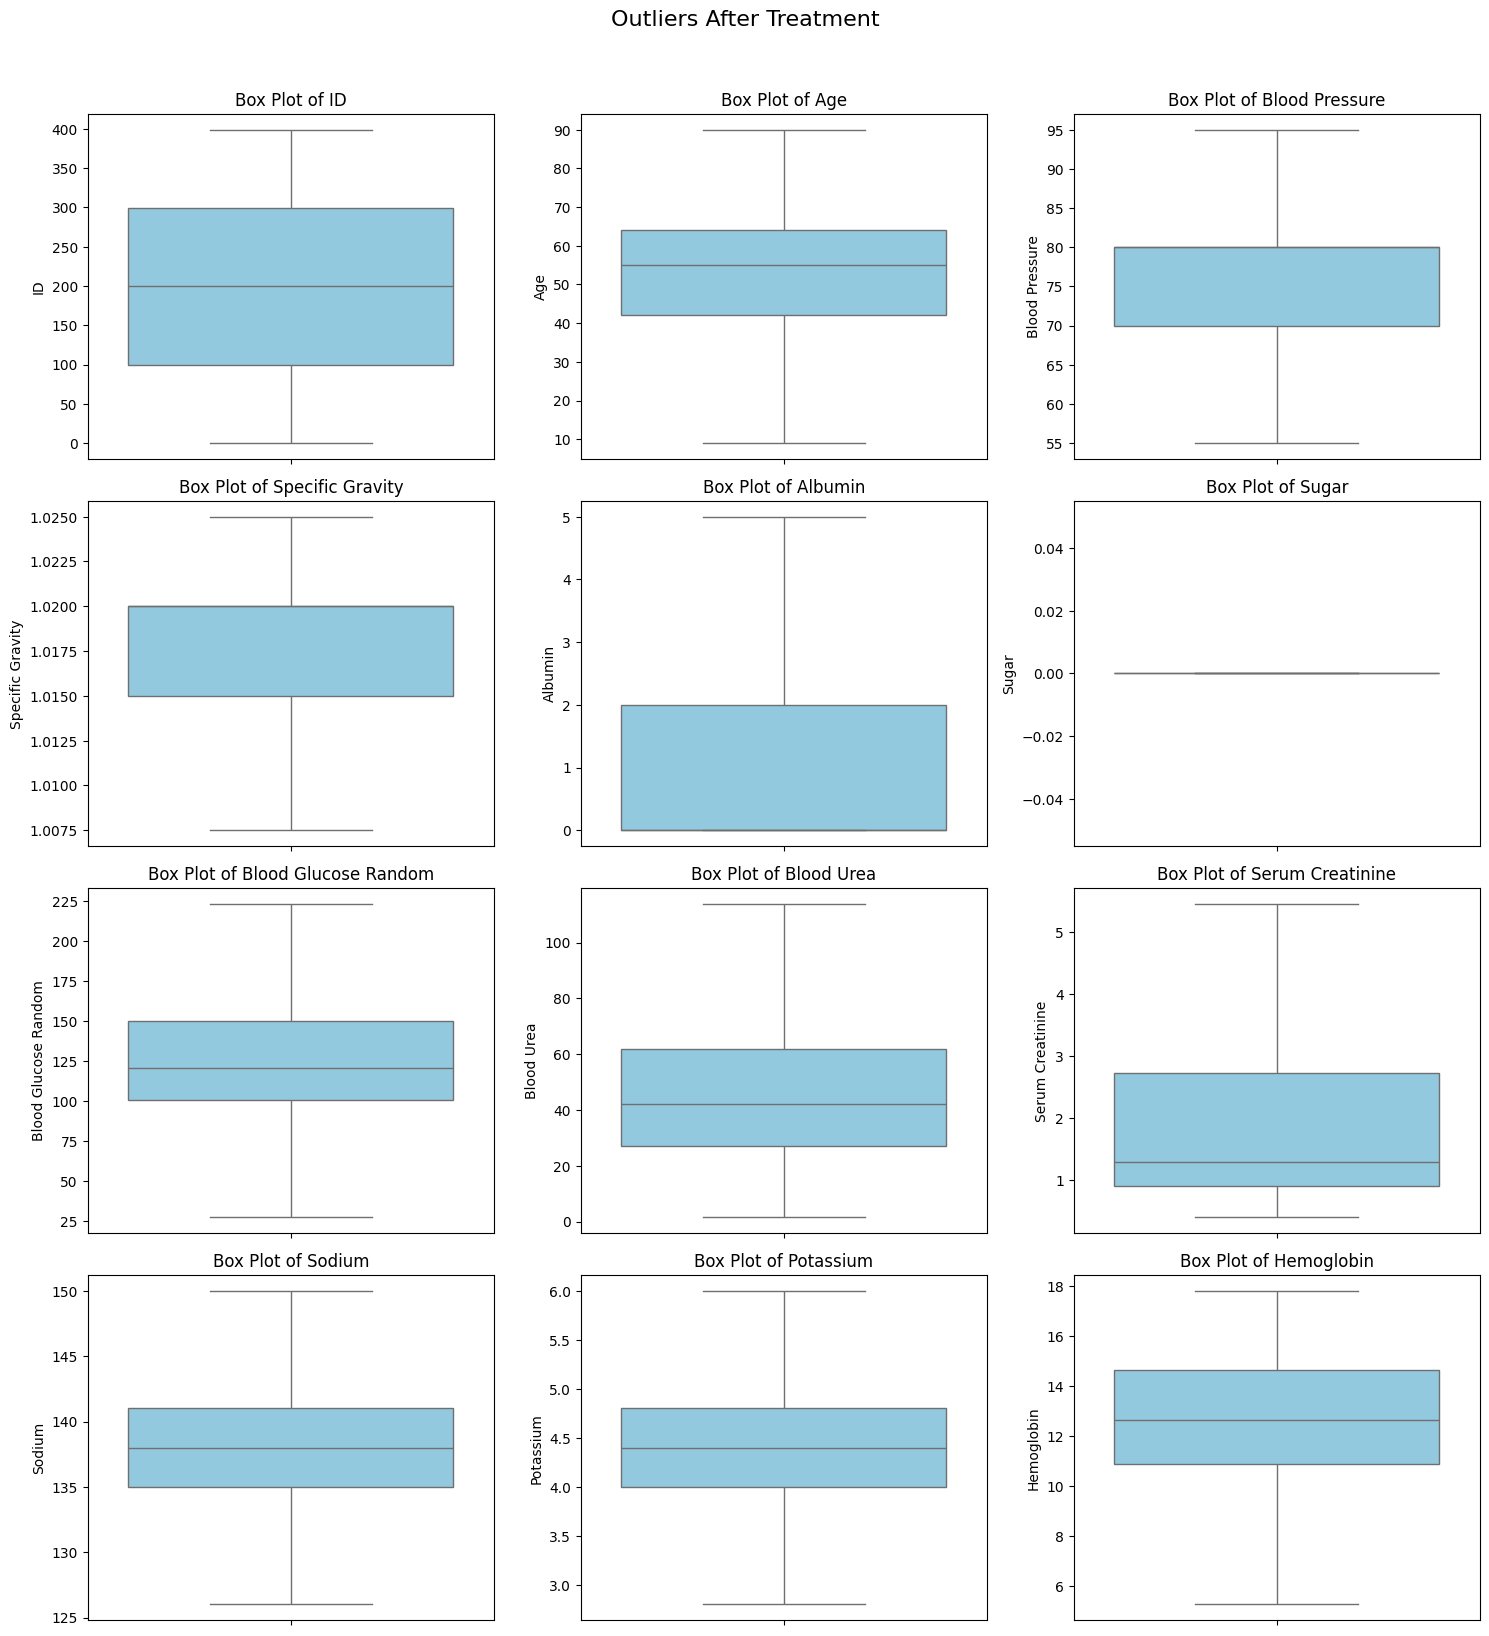


Data after encoding and scaling:
         ID       Age  Blood Pressure  Specific Gravity   Albumin  Sugar  \
0 -1.727726 -0.217955        0.381013          0.420662  0.076249    0.0   
1 -1.719066 -2.548388       -1.900504          0.420662  2.363728    0.0   
2 -1.710406  0.618610        0.381013         -1.454156  0.838742    0.0   
3 -1.701745 -0.217955       -0.531594         -1.922860  2.363728    0.0   
4 -1.693085 -0.038691        0.381013         -1.454156  0.838742    0.0   

   Red Blood Cells  Pus Cell  Pus Cell Clumps  Bacteria  ...  \
0                1         1                0         0  ...   
1                1         1                0         0  ...   
2                1         1                0         0  ...   
3                1         0                1         0  ...   
4                1         1                0         0  ...   

   Packed Cell Volume  White Blood Cell Count  Red Blood Cell Count  \
0                  31                      71        

In [52]:
# Assuming your dataset is loaded into CKD_data
processed_data = preprocess_data(CKD_data)

Variance Inflation Factor (VIF):
                 Feature           VIF
0                  const  53937.041163
1                    Age      1.107525
2         Blood Pressure      1.121064
3       Specific Gravity      1.545864
4                Albumin      1.567571
5                  Sugar      1.818931
6   Blood Glucose Random      1.797435
7             Blood Urea      2.181824
8       Serum Creatinine      2.397746
9                 Sodium      1.887444
10             Potassium      1.241974
11            Hemoglobin      2.000912


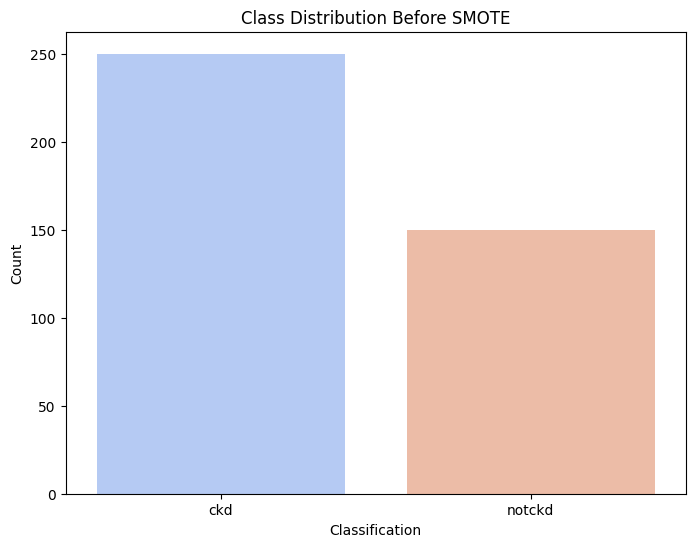

Class Imbalance:
Classification
ckd       250
notckd    150
Name: count, dtype: int64


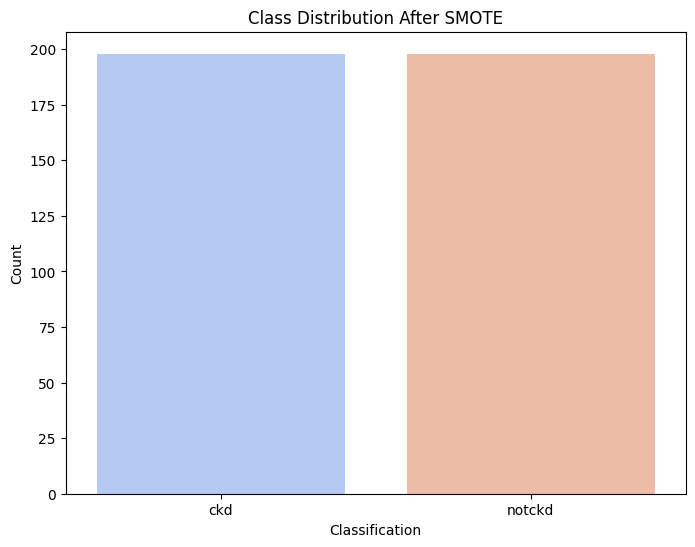

Class Distribution After SMOTE:
Classification
ckd       198
notckd    198
Name: count, dtype: int64


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for the features.

    Parameters:
    X (pd.DataFrame): Dataset for which to calculate VIF.

    Returns:
    pd.DataFrame: DataFrame containing features and their VIF values.
    """
    # Ensure input only contains numerical data
    X_numeric = X.select_dtypes(include=['float64', 'int64'])
    X_numeric = add_constant(X_numeric)  # Add constant term for intercept
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
    print("Variance Inflation Factor (VIF):")
    print(vif_data)
    return vif_data

def apply_smote(X, y):
    """
    Apply SMOTE to handle class imbalance.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.

    Returns:
    Tuple: Resampled features and target variable.
    """
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# After preprocessing numerical and categorical features
# Exclude target ('Classification') and identifier ('ID') for VIF calculation
X_for_vif = CKD_data.drop(columns=['Classification', 'ID'])

# Calculate VIF (only numeric columns)
vif_data = calculate_vif(X_for_vif)

# Check for class imbalance in the target variable
# Class distribution before SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(data=CKD_data, x='Classification', palette='coolwarm')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

# Count of each class
class_counts = CKD_data['Classification'].value_counts()
print("Class Imbalance:")
print(class_counts)

# Step 3: Data Splitting and Balancing

# Ensure all features in X are numeric before SMOTE
X_numeric = X_for_vif.select_dtypes(include=['float64', 'int64'])
y = CKD_data['Classification']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training dataset
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)

# Class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled, palette='coolwarm')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

print(f"Class Distribution After SMOTE:\n{pd.Series(y_train_resampled).value_counts()}")


## Exploratory Data Analysis (EDA)

Plotting numeric feature distributions...


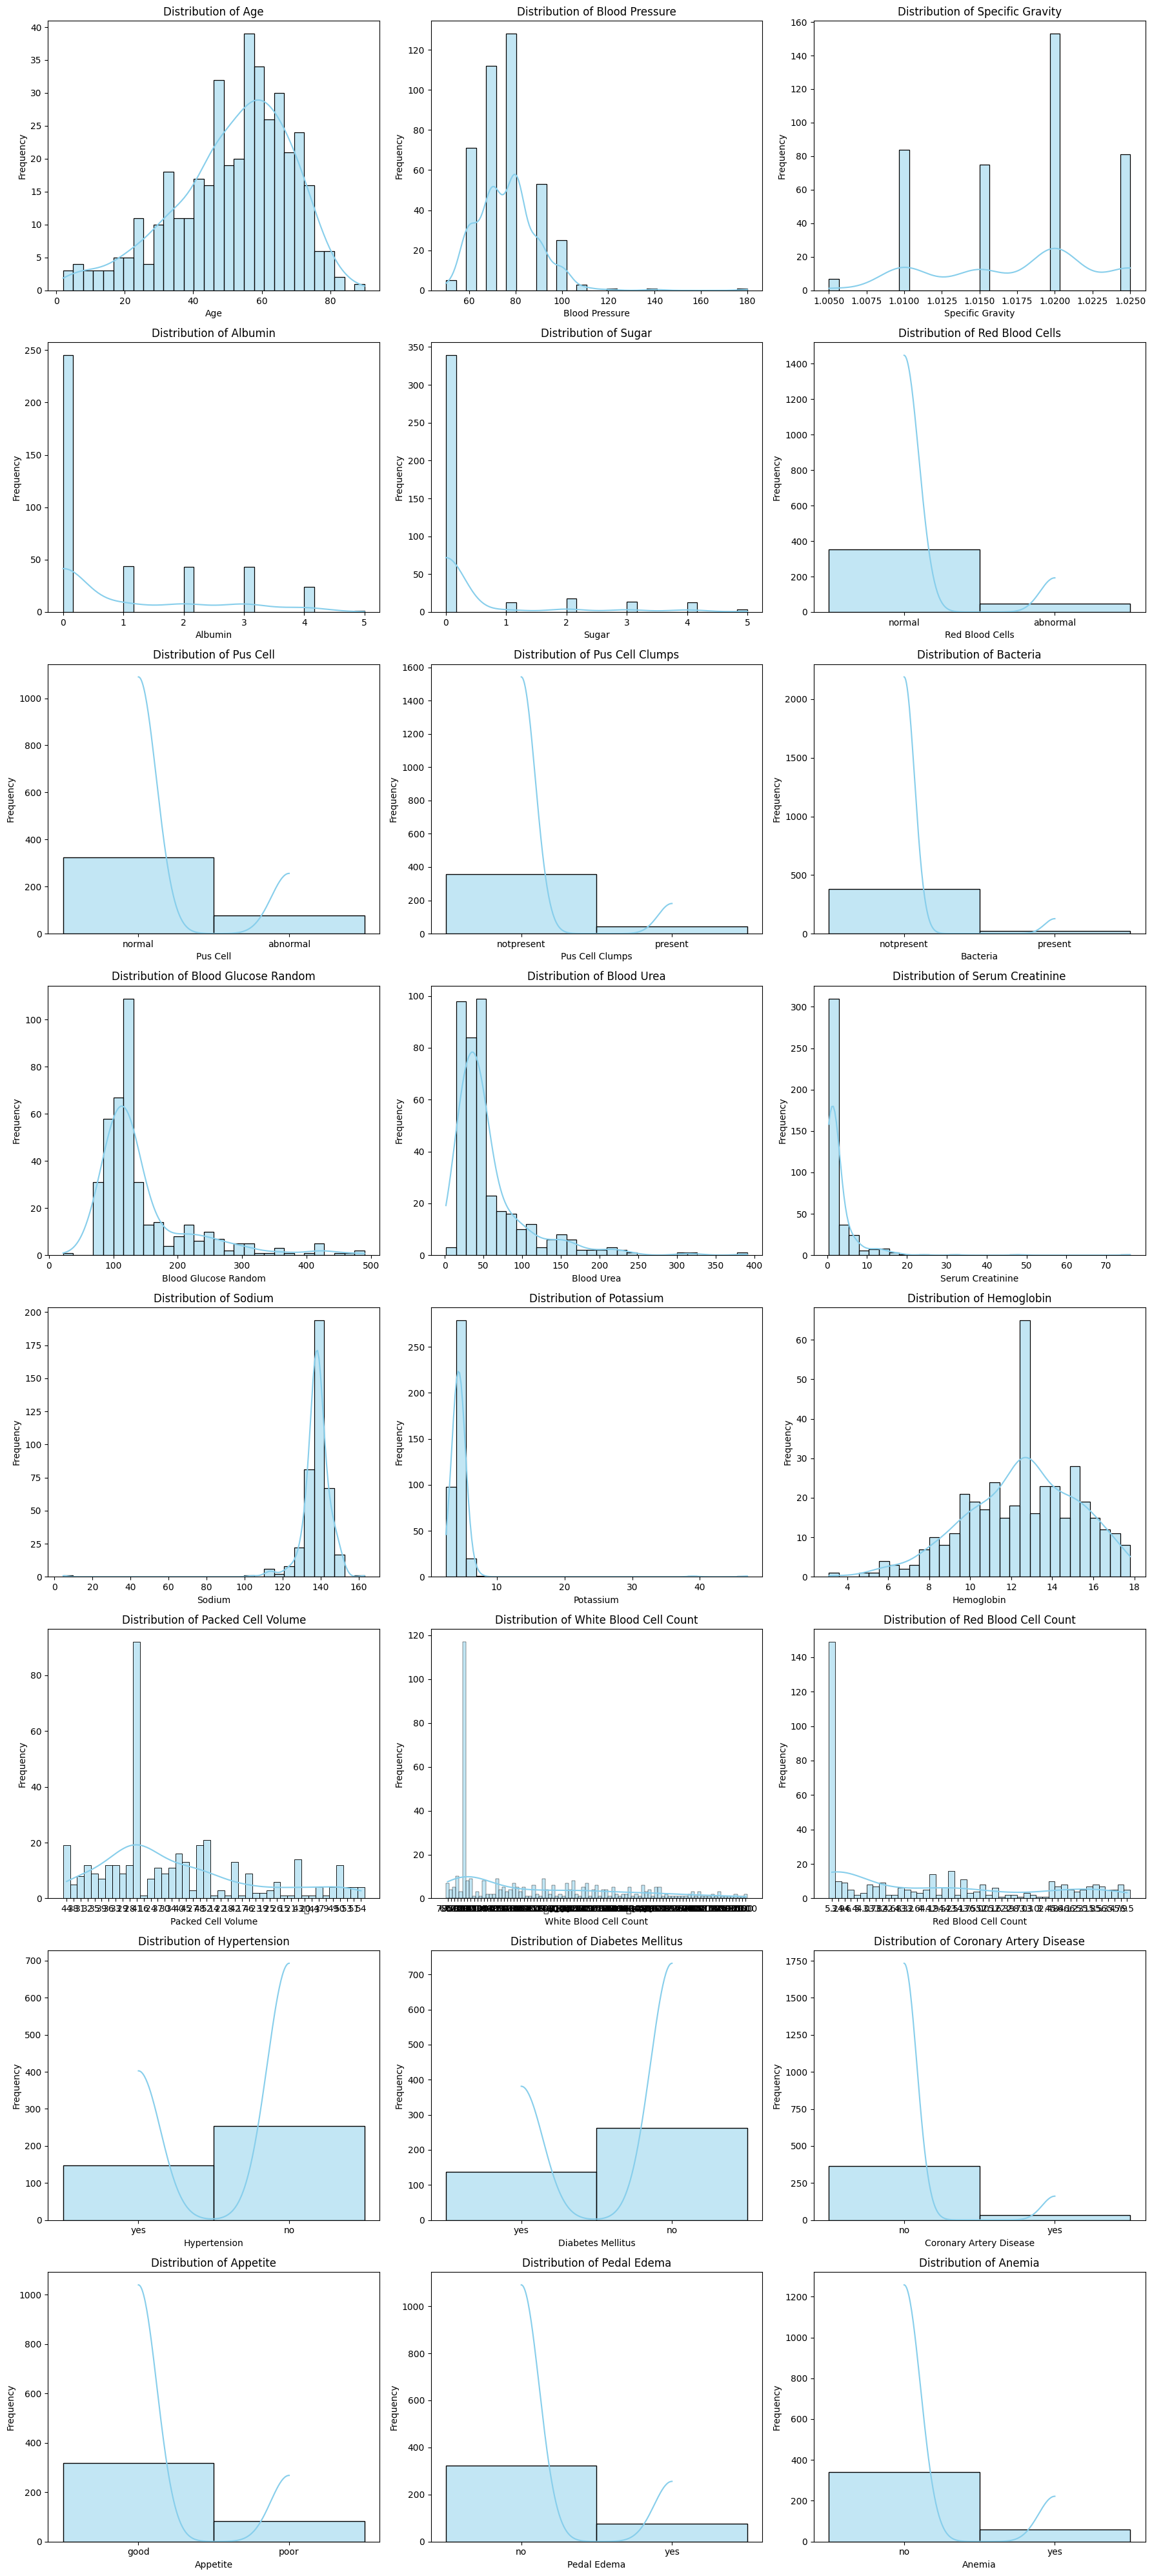

Plotting categorical feature counts...


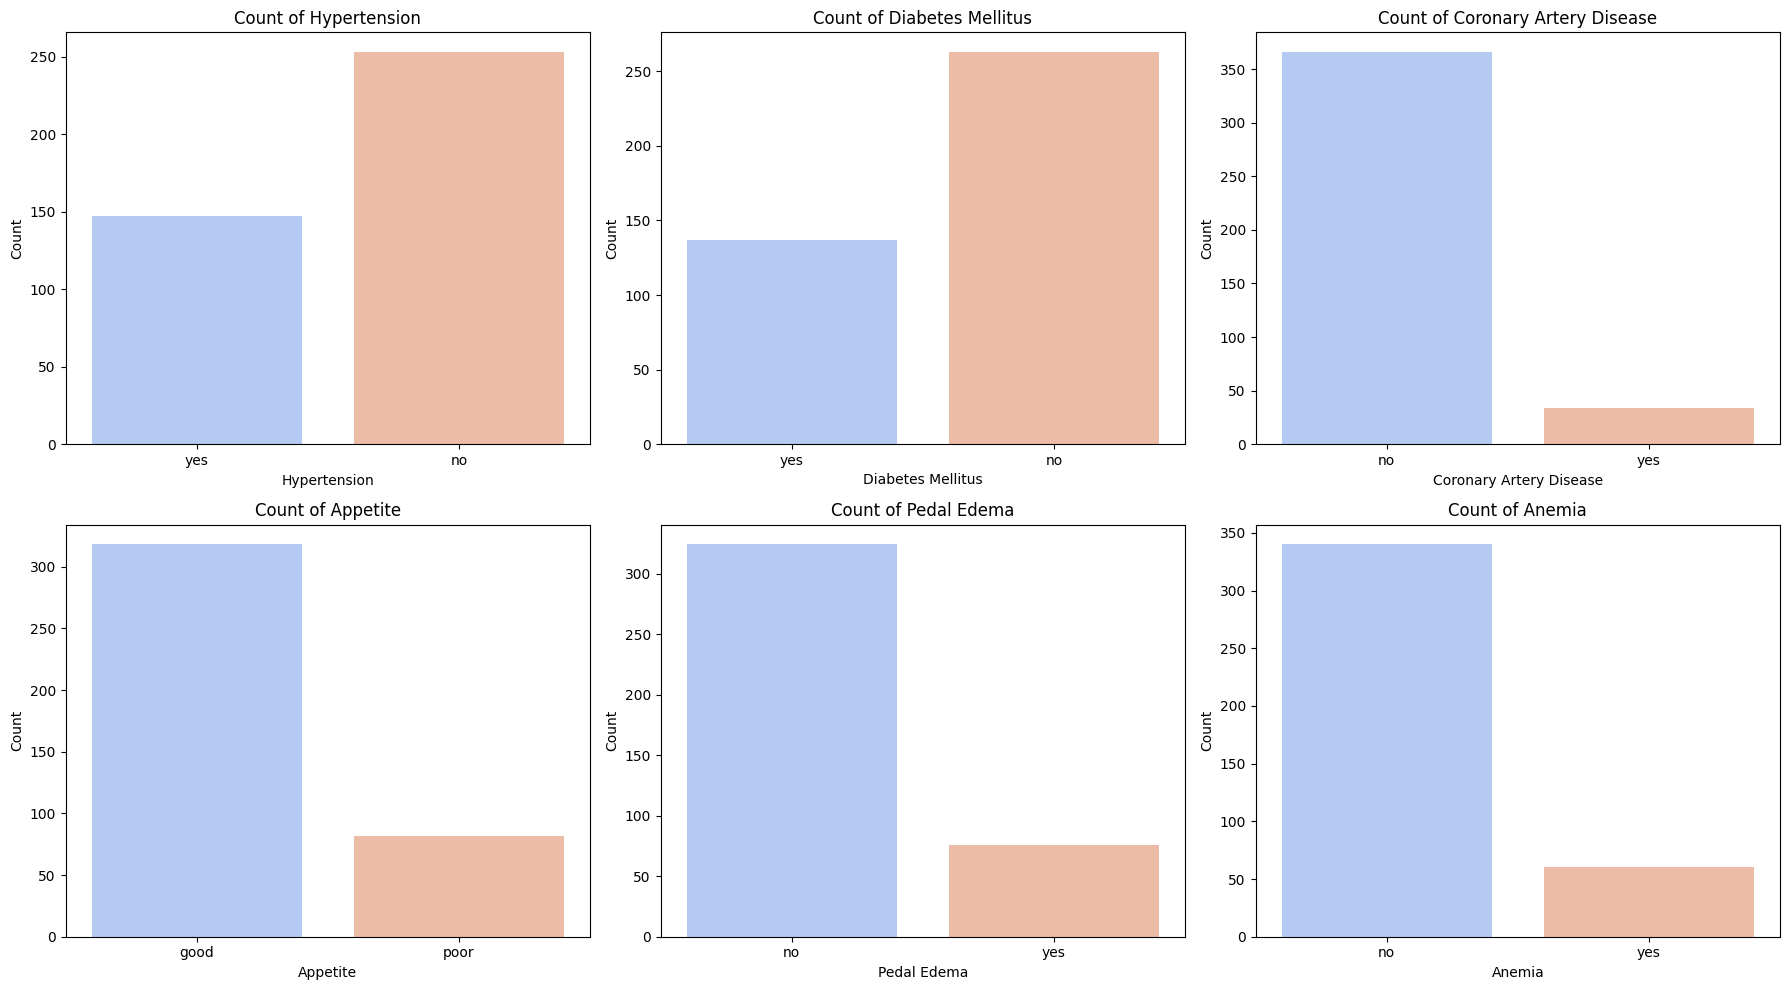

Plotting correlation heatmap...


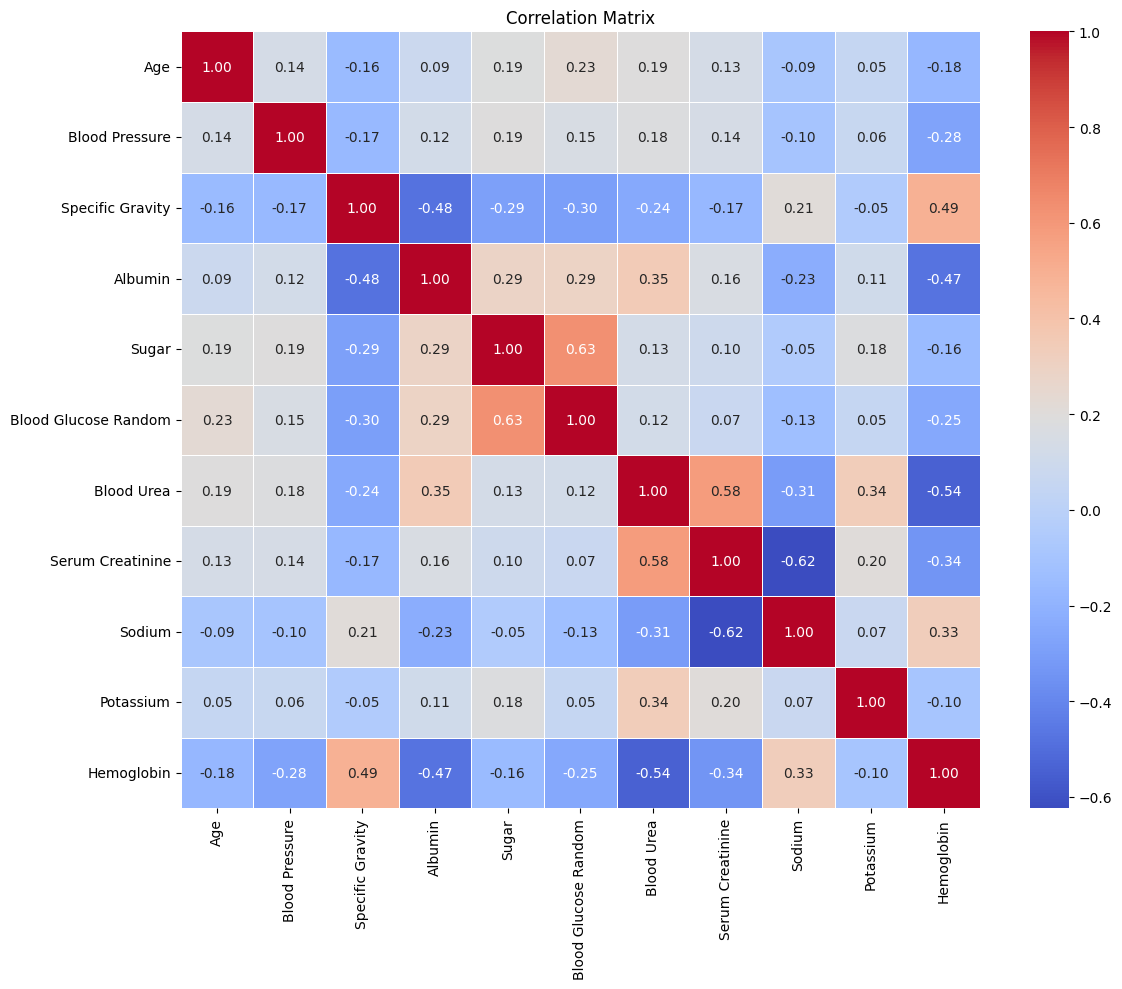

In [55]:
# Exploratory Data Analysis (EDA)
def plot_distributions(data, numeric_cols):
    """
    Plot distributions of numeric features.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric column names.
    """
    num_plots = len(numeric_cols)
    rows = (num_plots // 3) + (num_plots % 3 > 0)  # 3 plots per row
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(data[col], kde=True, bins=30, color='skyblue', ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_categorical_counts(data, categorical_cols):
    """
    Plot count plots for categorical variables.

    Parameters:
    data (pd.DataFrame): The dataset.
    categorical_cols (list): List of categorical column names.
    """
    num_plots = len(categorical_cols)
    rows = (num_plots // 3) + (num_plots % 3 > 0)  # 3 plots per row
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=data[col], palette="coolwarm", ax=axes[i])
        axes[i].set_title(f"Count of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Remove unused subplots

    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(data):
    """
    Plot a correlation heatmap for the dataset.

    Parameters:
    data (pd.DataFrame): The dataset.
    """
    # Exclude the 'ID' column and select only numeric columns
    numeric_data = data.drop(columns=['ID']).select_dtypes(include=['float64', 'int64'])

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()


# Perform EDA
numeric_cols = [col for col in X_for_vif.columns if col != 'ID']  # Exclude 'ID'
categorical_cols = ['Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
                    'Appetite', 'Pedal Edema', 'Anemia']  # Categorical columns

print("Plotting numeric feature distributions...")
plot_distributions(CKD_data, numeric_cols)

print("Plotting categorical feature counts...")
plot_categorical_counts(CKD_data, categorical_cols)

print("Plotting correlation heatmap...")
plot_correlation_heatmap(CKD_data)


In [42]:
def detect_and_remove_outliers(data, numeric_cols):
    """
    Detect and remove outliers using the IQR method.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric columns to check for outliers.

    Returns:
    pd.DataFrame: Dataset with outliers removed.
    """
    print("Checking for outliers...")
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detect outliers
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        print(f"{col}: {len(outliers)} outliers detected.")

        # Remove outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

    return data


# Step 2: Add Outlier Detection to Preprocessing
numeric_cols = CKD_data.select_dtypes(include=['float64', 'int64']).columns
CKD_data_cleaned = detect_and_remove_outliers(CKD_data, numeric_cols)

# Recheck the dataset
print("\nData after removing outliers:")
print(CKD_data_cleaned.describe())


Checking for outliers...
ID: 0 outliers detected.
Age: 10 outliers detected.
Blood Pressure: 33 outliers detected.
Specific Gravity: 6 outliers detected.
Albumin: 47 outliers detected.
Sugar: 31 outliers detected.
Blood Glucose Random: 22 outliers detected.
Blood Urea: 31 outliers detected.
Serum Creatinine: 17 outliers detected.
Sodium: 0 outliers detected.
Potassium: 0 outliers detected.
Hemoglobin: 0 outliers detected.
Hypertension: 22 outliers detected.
Diabetes Mellitus: 5 outliers detected.
Coronary Artery Disease: 0 outliers detected.
Appetite: 5 outliers detected.
Pedal Edema: 3 outliers detected.
Anemia: 1 outliers detected.
Classification: 17 outliers detected.

Data after removing outliers:
               ID         Age  Blood Pressure  Specific Gravity  Albumin  \
count  150.000000  150.000000      150.000000        150.000000    150.0   
mean   324.500000   46.573333       71.466667          1.022333      0.0   
std     43.445368   15.593987        8.544135          0.0025

Training and evaluating models...
Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.96      0.96      0.96        28

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



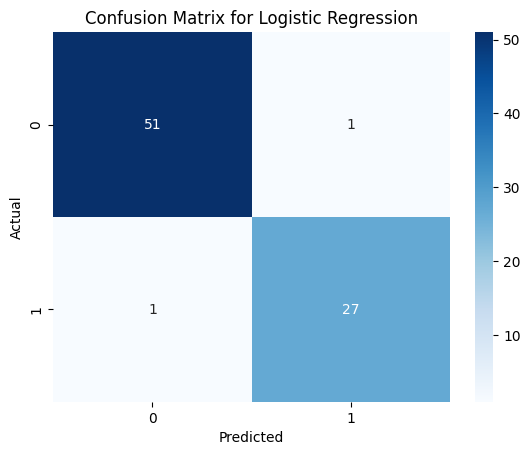

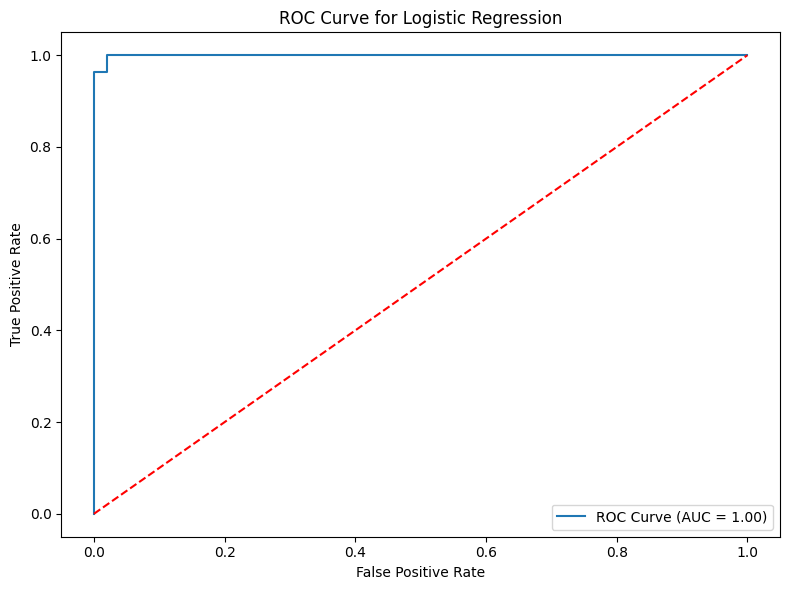

Training Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.97      1.00      0.98        28

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



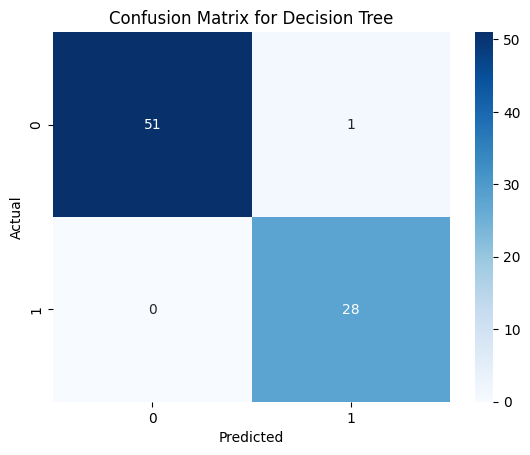

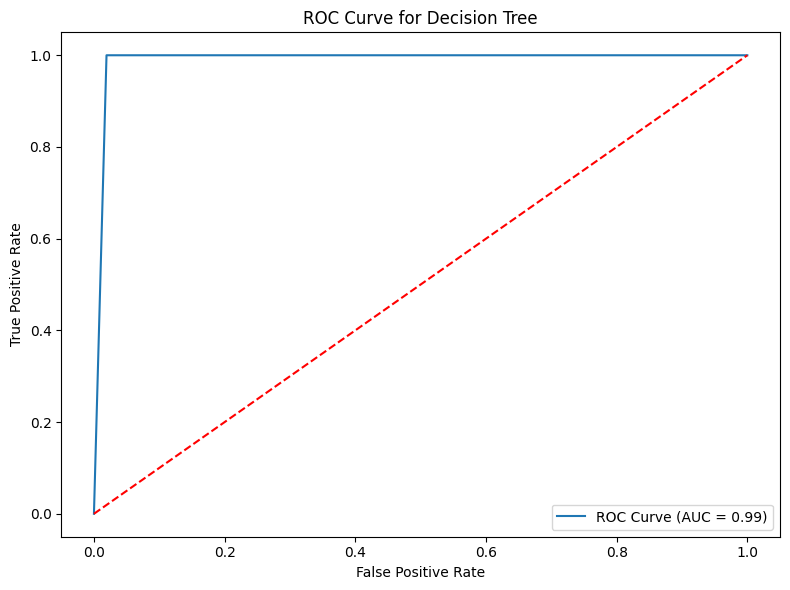

Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        28

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



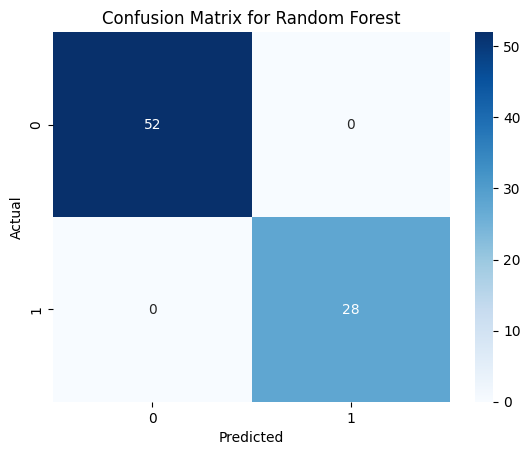

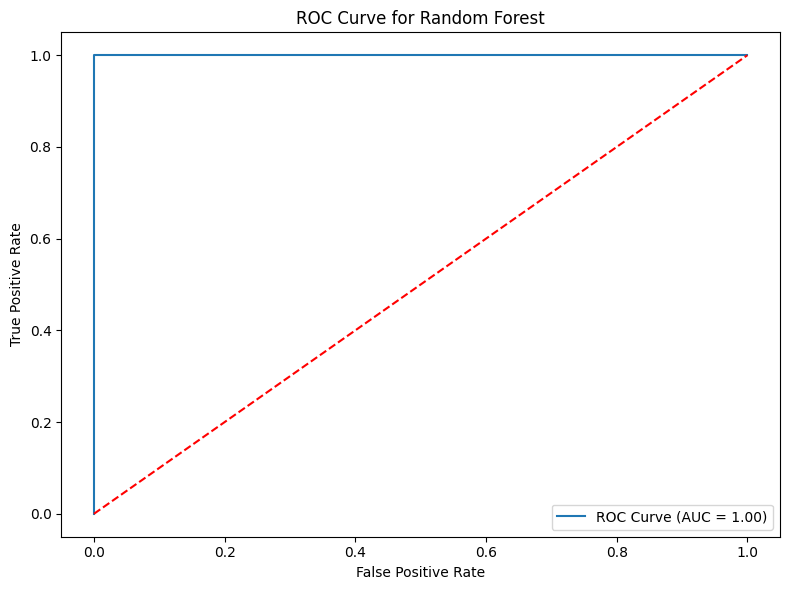

Training SVM (Linear Kernel)...

Classification Report for SVM (Linear Kernel):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.96      0.98        28

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80



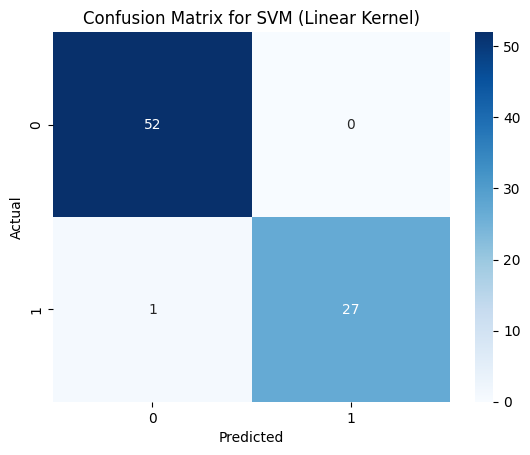

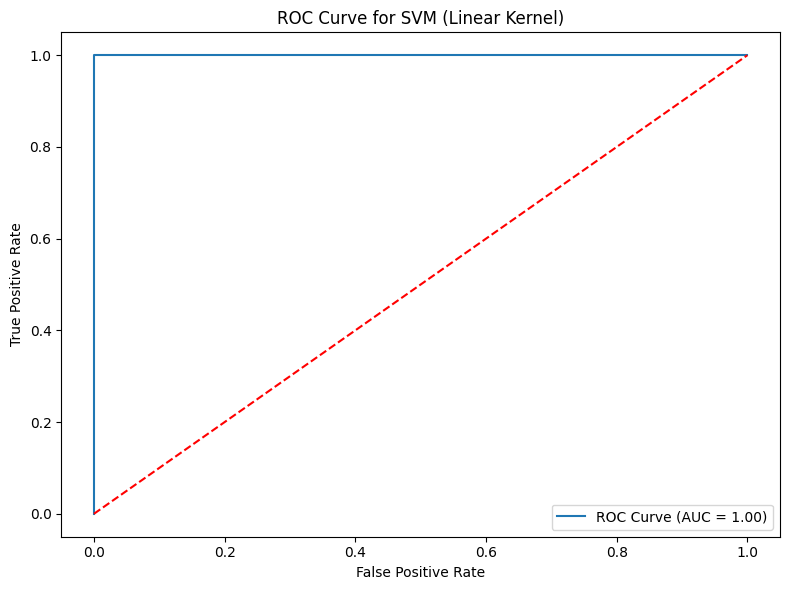

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    """
    Train and evaluate multiple models.

    Parameters:
    models (dict): Dictionary of model names and their corresponding instances.
    X_train, y_train: Training dataset.
    X_test, y_test: Testing dataset.
    """
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Print classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC-AUC Curve
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = roc_auc_score(y_test, y_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], 'r--')
            plt.title(f"ROC Curve for {name}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.tight_layout()
            plt.show()


# Step 4: Model Training and Evaluation
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True, random_state=42)
}

print("Training and evaluating models...")
train_and_evaluate(models, X_train_resampled, y_train_resampled, X_test, y_test)


In [ ]:
# Define the standard column names in the same order as they appear in the CKD_Data DataFrame
CKD_Data.columns = [
    'ID', 'Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
    'Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
    'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Sodium',
    'Potassium', 'Hemoglobin', 'Packed Cell Volume', 'White Blood Cell Count',
    'Red Blood Cell Count', 'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
    'Appetite', 'Pedal Edema', 'Anemia', 'Classification'
]

# Displaying the updated CKD_Data DataFrame with new column names
print("Updated DataFrame with new column names:")
CKD_Data.head()

Updated DataFrame with new column names:


,ID,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell Clumps,Bacteria,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


## Initial Data Inspection
### View Dataset Summary

In [ ]:
# overall information of the CKD dataset
CKD_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       400 non-null    int64  
 1   Age                      391 non-null    float64
 2   Blood Pressure           388 non-null    float64
 3   Specific Gravity         353 non-null    float64
 4   Albumin                  354 non-null    float64
 5   Sugar                    351 non-null    float64
 6   Red Blood Cells          248 non-null    object 
 7   Pus Cell                 335 non-null    object 
 8   Pus Cell Clumps          396 non-null    object 
 9   Bacteria                 396 non-null    object 
 10  Blood Glucose Random     356 non-null    float64
 11  Blood Urea               381 non-null    float64
 12  Serum Creatinine         383 non-null    float64
 13  Sodium                   313 non-null    float64
 14  Potassium                3

In [ ]:
# description of the CKD  dataset
CKD_Data.describe()

,ID,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Blood Glucose Random,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [ ]:
# View the missing values in CKD_Data

print("\nMissing values in CKD Dataset: ")
print(CKD_Data.isnull().sum())


Missing values in CKD Dataset: 
ID                           0
Age                          9
Blood Pressure              12
Specific Gravity            47
Albumin                     46
Sugar                       49
Red Blood Cells            152
Pus Cell                    65
Pus Cell Clumps              4
Bacteria                     4
Blood Glucose Random        44
Blood Urea                  19
Serum Creatinine            17
Sodium                      87
Potassium                   88
Hemoglobin                  52
Packed Cell Volume          70
White Blood Cell Count     105
Red Blood Cell Count       130
Hypertension                 2
Diabetes Mellitus            2
Coronary Artery Disease      2
Appetite                     1
Pedal Edema                  1
Anemia                       1
Classification               0
dtype: int64


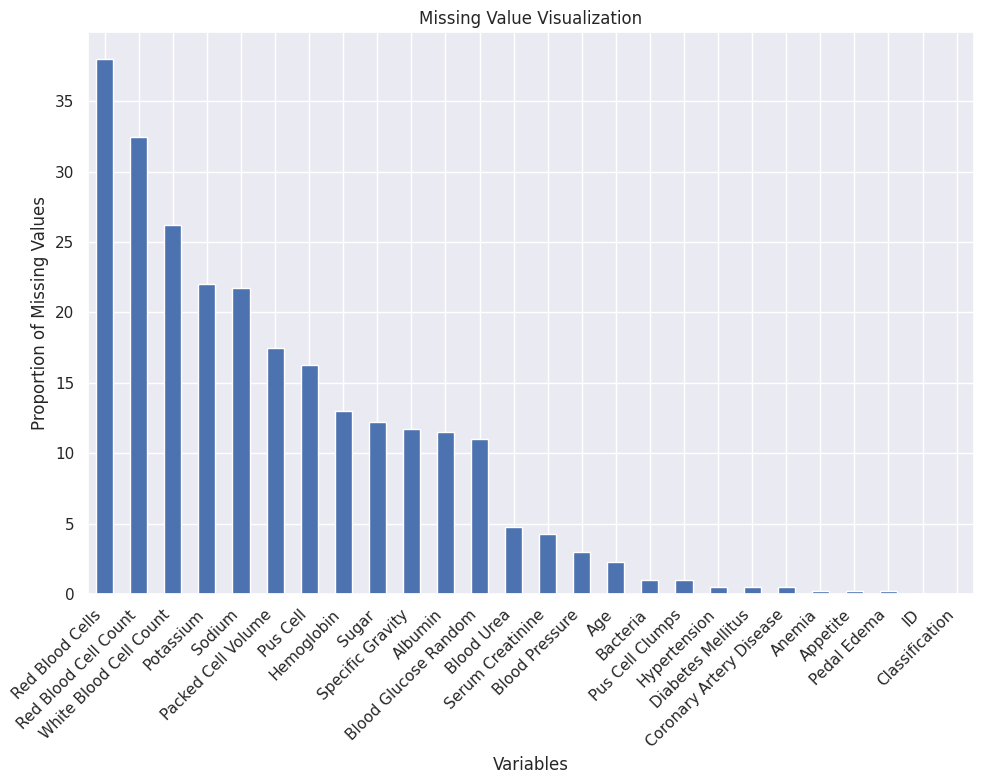

In [ ]:
# Visualize missing values
# Count of number of missing values in each column
missing_values = (CKD_Data.isna().sum()/CKD_Data.shape[0]*100).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
missing_values.plot(kind='bar')
plt.title('Missing Value Visualization')
plt.xlabel('Variables')
plt.ylabel('Proportion of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Replacing non-standard values in multiple columns

# Replacing non-standard values in 'Classification' column
CKD_Data['Classification'] = CKD_Data['Classification'].str.replace('ckd\t', 'ckd', regex=False)

# Verifing  unique values in the 'Classification' column after replacement
print("Unique values in 'Classification' after replacement:")
print(CKD_Data['Classification'].unique())

# Replacing non-standard values in 'Diabetes Mellitus' and 'Coronary Artery Disease' columns
CKD_Data['Diabetes Mellitus'].replace(to_replace={'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'}, inplace=True)
CKD_Data['Coronary Artery Disease'].replace(to_replace={'\tno': 'no'}, inplace=True)

# Verifying  unique values in each column
print("Unique values in 'Diabetes Mellitus' after replacement:")
print(CKD_Data['Diabetes Mellitus'].unique())

print("Unique values in 'Coronary Artery Disease' after replacement:")
print(CKD_Data['Coronary Artery Disease'].unique())

Unique values in 'Classification' after replacement:
['ckd' 'notckd']
Unique values in 'Diabetes Mellitus' after replacement:
['yes' 'no' nan]
Unique values in 'Coronary Artery Disease' after replacement:
['no' 'yes' nan]


In [ ]:
# Classifying columns : categorical columns and numerical columns
cat_cols = [col for col in CKD_Data.columns if CKD_Data[col].dtype=='object']
num_cols = [col for col in CKD_Data.columns if CKD_Data[col].dtype!='object']

In [ ]:
# Displaying the  counts and names of the columns
print(f"Count of categorical columns: {len(cat_cols)}")
print("Categorical columns:", cat_cols)

print(f"\nCount of numerical columns: {len(num_cols)}")
print("Numerical columns:", num_cols)


Count of categorical columns: 14
Categorical columns: ['Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria', 'Packed Cell Volume', 'White Blood Cell Count', 'Red Blood Cell Count', 'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease', 'Appetite', 'Pedal Edema', 'Anemia', 'Classification']

Count of numerical columns: 12
Numerical columns: ['ID', 'Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar', 'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Sodium', 'Potassium', 'Hemoglobin']


In [ ]:
CKD_Data.groupby('Classification').count()

,ID,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell Clumps,Bacteria,...,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia
Classification,,,,,,,,,,,,,,,,,,,,,
ckd,250,242,240,208,209,206,107,194,250,250,...,204,184,152,127,250,250,250,250,250,250
notckd,150,149,148,145,145,145,141,141,146,146,...,144,146,143,143,148,148,148,149,149,149


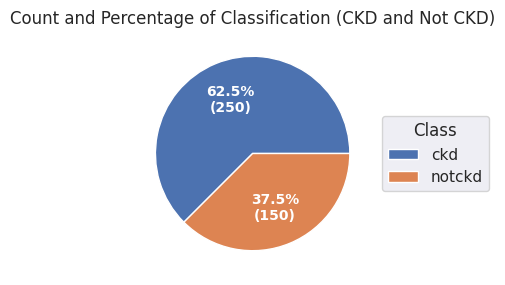

In [ ]:
# Count classifications
classification_counts = CKD_Data['Classification'].value_counts().sort_index()

# Prepare data for pie chart
types = classification_counts.index.values
values = classification_counts.values

# Create pie chart
fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(
    values,
    labels=types,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*np.sum(values))})",
    textprops=dict(color="w"),
)

# Add legend and title
ax.legend(title="Class", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Count and Percentage of Classification (CKD and Not CKD)")

plt.setp(autotexts, size=10, weight="bold")
plt.show()


### Converting specific columns in a dataset from the object type to a numeric type, which is necessary for numerical analysis

In [ ]:
# Convert object type to numeric type
CKD_Data['Packed Cell Volume']     = pd.to_numeric(CKD_Data['Packed Cell Volume'], errors='coerce')
CKD_Data['White Blood Cell Count'] = pd.to_numeric(CKD_Data['White Blood Cell Count'], errors='coerce')
CKD_Data['Red Blood Cell Count']   = pd.to_numeric(CKD_Data['Red Blood Cell Count'], errors='coerce')
CKD_Data

,ID,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell Clumps,Bacteria,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


## Handle Missing Data
### Numerical Columns: Fill missing values with the median.
### Categorical Columns: Fill missing values with the mode (most frequent value).

### Checking for Missing Values After Imputation

In [ ]:
# Fill missing values for numeric columns with the median
for column in CKD_Data.select_dtypes(include=['float64', 'int64']).columns:
    CKD_Data[column].fillna(CKD_Data[column].median(), inplace=True)

# Fill missing values for categorical columns with the mode
for column in CKD_Data.select_dtypes(include=['object']).columns:
    CKD_Data[column].fillna(CKD_Data[column].mode()[0], inplace=True)

# Verifying that there are no more missing values
print("\nMissing Values After Imputation:")
print(CKD_Data.isnull().sum())


Missing Values After Imputation:
ID                         0
Age                        0
Blood Pressure             0
Specific Gravity           0
Albumin                    0
Sugar                      0
Red Blood Cells            0
Pus Cell                   0
Pus Cell Clumps            0
Bacteria                   0
Blood Glucose Random       0
Blood Urea                 0
Serum Creatinine           0
Sodium                     0
Potassium                  0
Hemoglobin                 0
Packed Cell Volume         0
White Blood Cell Count     0
Red Blood Cell Count       0
Hypertension               0
Diabetes Mellitus          0
Coronary Artery Disease    0
Appetite                   0
Pedal Edema                0
Anemia                     0
Classification             0
dtype: int64


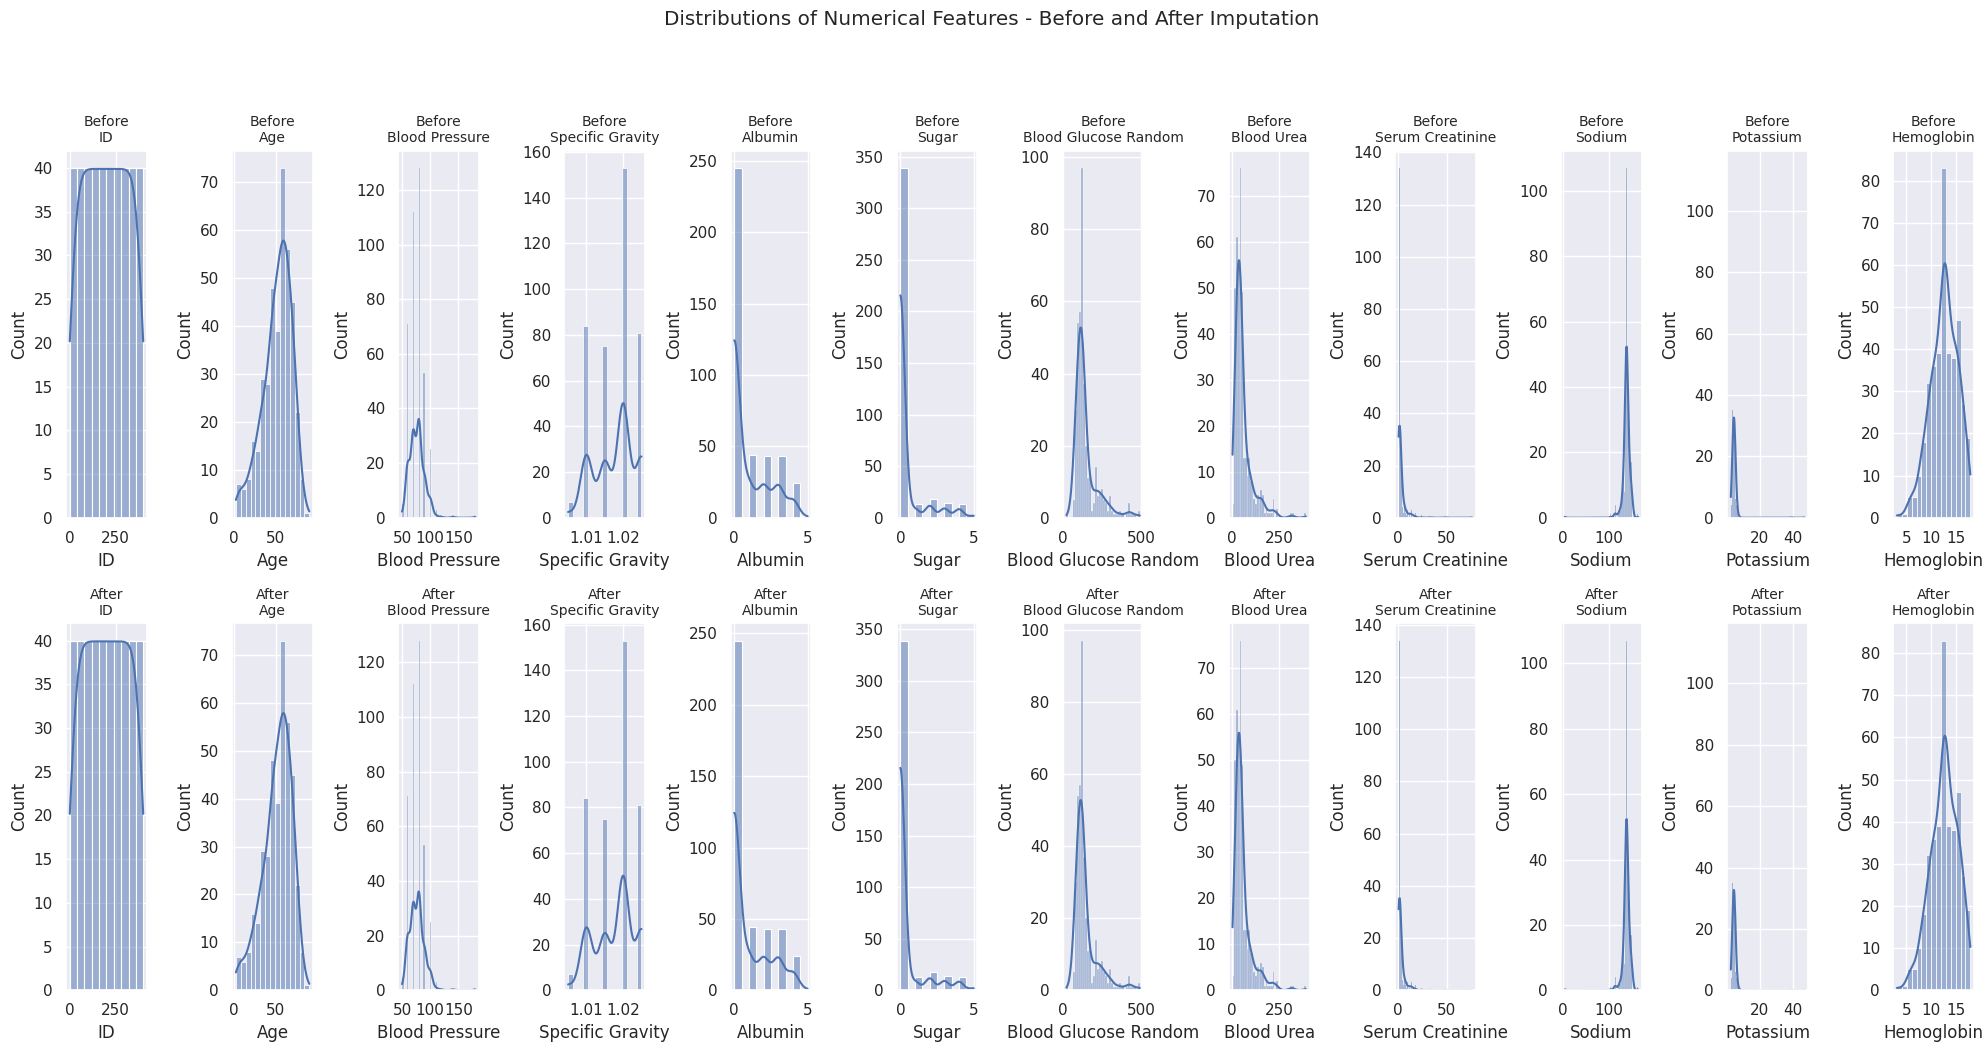

In [ ]:
# Plot distributions before and after imputation

fig, axes = plt.subplots(nrows=2, ncols=len(num_cols), figsize=(20, 10))
fig.suptitle('Distributions of Numerical Features - Before and After Imputation', y=1.05)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Before imputation
for i, col in enumerate(num_cols):
    sns.histplot(CKD_Data[col], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'Before\n{col}', fontsize=10)

# After imputation
for i, col in enumerate(num_cols):
    sns.histplot(CKD_Data[col], kde=True, ax=axes[1, i])
    axes[1, i].set_title(f'After\n{col}', fontsize=10)

plt.tight_layout()
plt.show()


## Outlier Detection and Removal
### Using the IQR method to detect outliers for 'White Blood Cell Count' and other numerical columns.

In [ ]:
# Calculate IQR for 'White Blood Cell Count'
Q1 = CKD_Data['White Blood Cell Count'].quantile(0.25)
Q3 = CKD_Data['White Blood Cell Count'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers using IQR
outliers_iqr = CKD_Data[(CKD_Data['White Blood Cell Count'] < lower_bound) |
                       (CKD_Data['White Blood Cell Count'] > upper_bound)]

print("Outliers using IQR method:")
print(outliers_iqr)


Outliers using IQR method:
      ID   Age  Blood Pressure  Specific Gravity  Albumin  Sugar  \
48    48  73.0            70.0             1.005      0.0    0.0   
49    49  60.0            70.0             1.010      2.0    0.0   
71    71  46.0            60.0             1.010      1.0    0.0   
88    88  58.0           110.0             1.010      4.0    0.0   
107  107  55.0           100.0             1.015      1.0    4.0   
123  123  43.0            80.0             1.015      2.0    3.0   
127  127  71.0            60.0             1.015      4.0    0.0   
130  130  50.0            90.0             1.010      2.0    0.0   
132  132  50.0            80.0             1.020      0.0    0.0   
147  147  60.0            60.0             1.010      3.0    1.0   
153  153  55.0            90.0             1.010      2.0    1.0   
167  167  34.0            70.0             1.020      0.0    0.0   
181  181  45.0            70.0             1.025      2.0    0.0   
190  190   6.0       

## Exploratory Data Analysis (EDA)
### Boxplot for Identifying Outliers

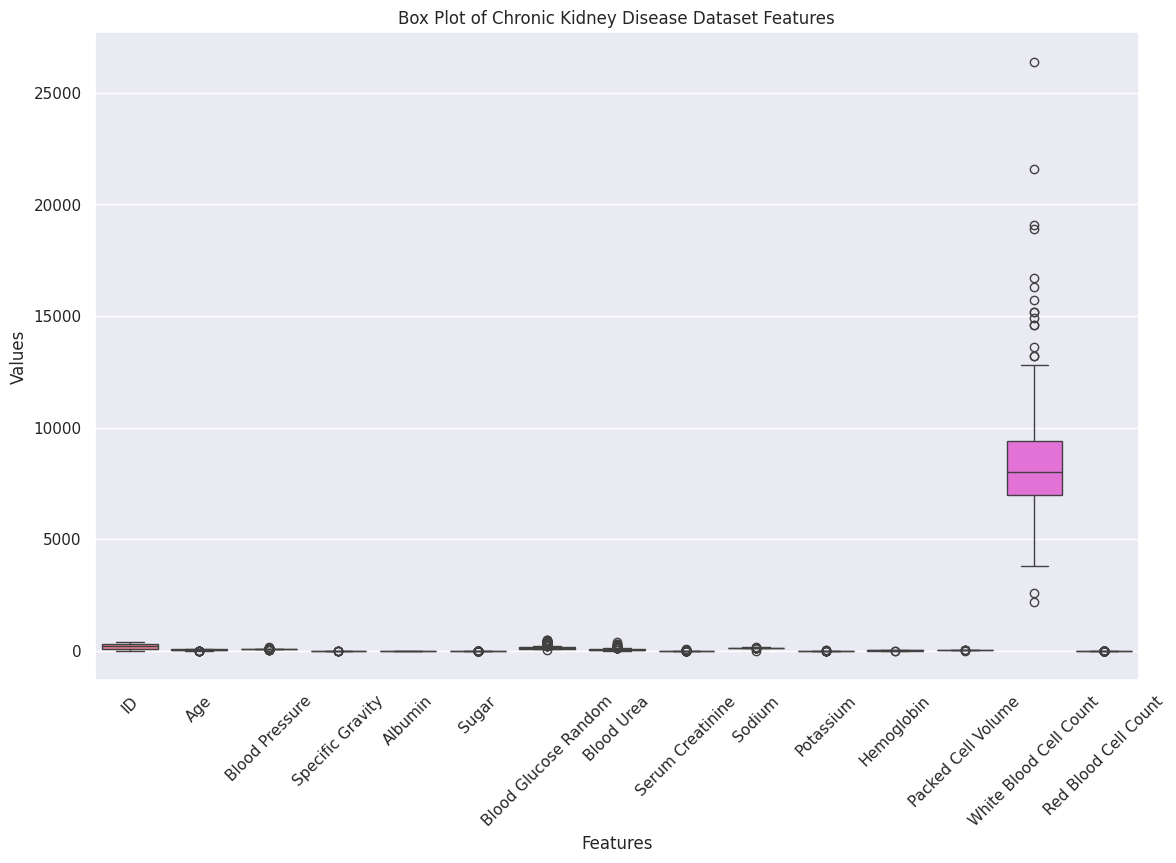

In [ ]:
# Boxplot for visualizing outliers in numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=CKD_Data)
plt.title('Box Plot of Chronic Kidney Disease Dataset Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


## Histogram for Distribution of Numerical Features

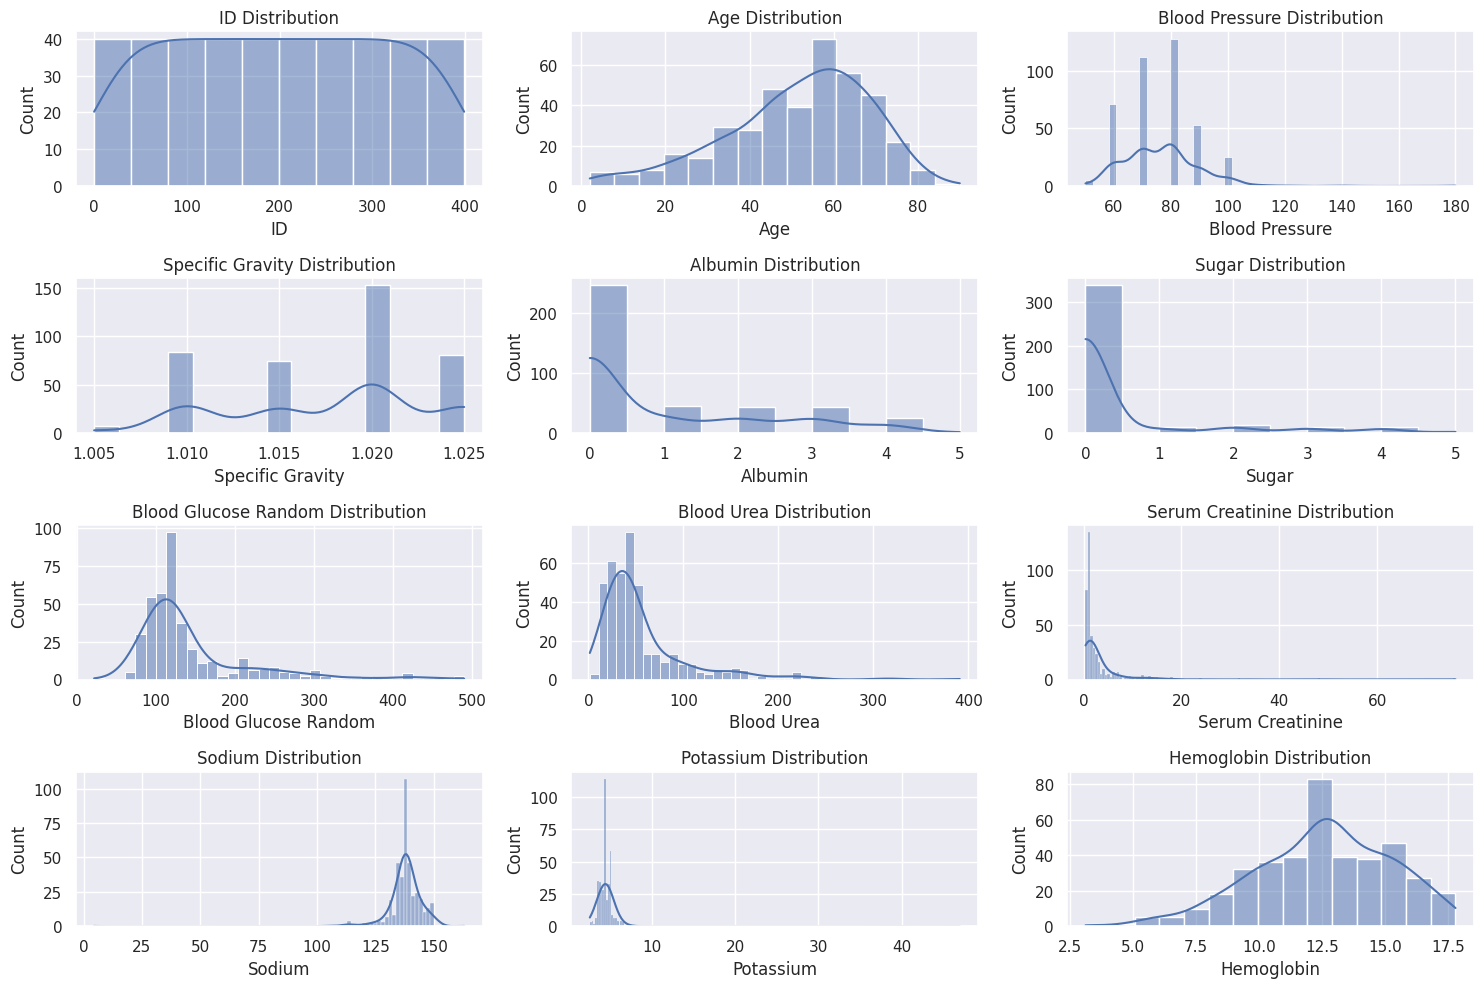

In [ ]:
# Visualizing the distribution of numerical columns
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(CKD_Data[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

## Feature Scaling
### Standardization using StandardScaler

In [ ]:
# Apply StandardScaler to numerical columns
scaler = StandardScaler()
CKD_Data[num_cols] = scaler.fit_transform(CKD_Data[num_cols])

# Check result after scaling
print(CKD_Data[num_cols].head())

         ID       Age  Blood Pressure  Specific Gravity   Albumin     Sugar  \
0 -1.727726 -0.210031        0.254214          0.421486  0.076249 -0.380269   
1 -1.719066 -2.627234       -1.972476          0.421486  2.363728 -0.380269   
2 -1.710406  0.615355        0.254214         -1.421074  0.838742  2.507853   
3 -1.701745 -0.210031       -0.488016         -2.342354  2.363728 -0.380269   
4 -1.693085 -0.033163        0.254214         -1.421074  0.838742 -0.380269   

   Blood Glucose Random  Blood Urea  Serum Creatinine    Sodium  Potassium  \
0             -0.320122   -0.419451         -0.319668  0.040104  -0.062903   
1             -0.320122   -0.784315         -0.390819  0.040104  -0.062903   
2              3.697618   -0.074858         -0.212942  0.040104  -0.062903   
3             -0.373337   -0.014047          0.142813 -2.896333  -0.737181   
4             -0.519679   -0.622154         -0.284093  0.040104  -0.062903   

   Hemoglobin  
0    1.053226  
1   -0.457965  
2   -1.0

### Normalization using MinMaxScaler

In [ ]:
#Apply MinMaxScaler to numerical columns
scaler = MinMaxScaler()
CKD_Data[num_cols] = scaler.fit_transform(CKD_Data[num_cols])

#Check result after normalization
print(CKD_Data[num_cols].head())

         ID       Age  Blood Pressure  Specific Gravity  Albumin  Sugar  \
0  0.000000  0.522727        0.230769              0.75      0.2    0.0   
1  0.002506  0.056818        0.000000              0.75      0.8    0.0   
2  0.005013  0.681818        0.230769              0.25      0.4    0.6   
3  0.007519  0.522727        0.153846              0.00      0.8    0.0   
4  0.010025  0.556818        0.230769              0.25      0.4    0.0   

   Blood Glucose Random  Blood Urea  Serum Creatinine    Sodium  Potassium  \
0              0.211538    0.088575          0.010582  0.842271   0.042697   
1              0.211538    0.042362          0.005291  0.842271   0.042697   
2              0.856838    0.132221          0.018519  0.842271   0.042697   
3              0.202991    0.139923          0.044974  0.671924   0.000000   
4              0.179487    0.062901          0.013228  0.842271   0.042697   

   Hemoglobin  
0    0.836735  
1    0.557823  
2    0.442177  
3    0.551020  


### Distribution of Scaled Features

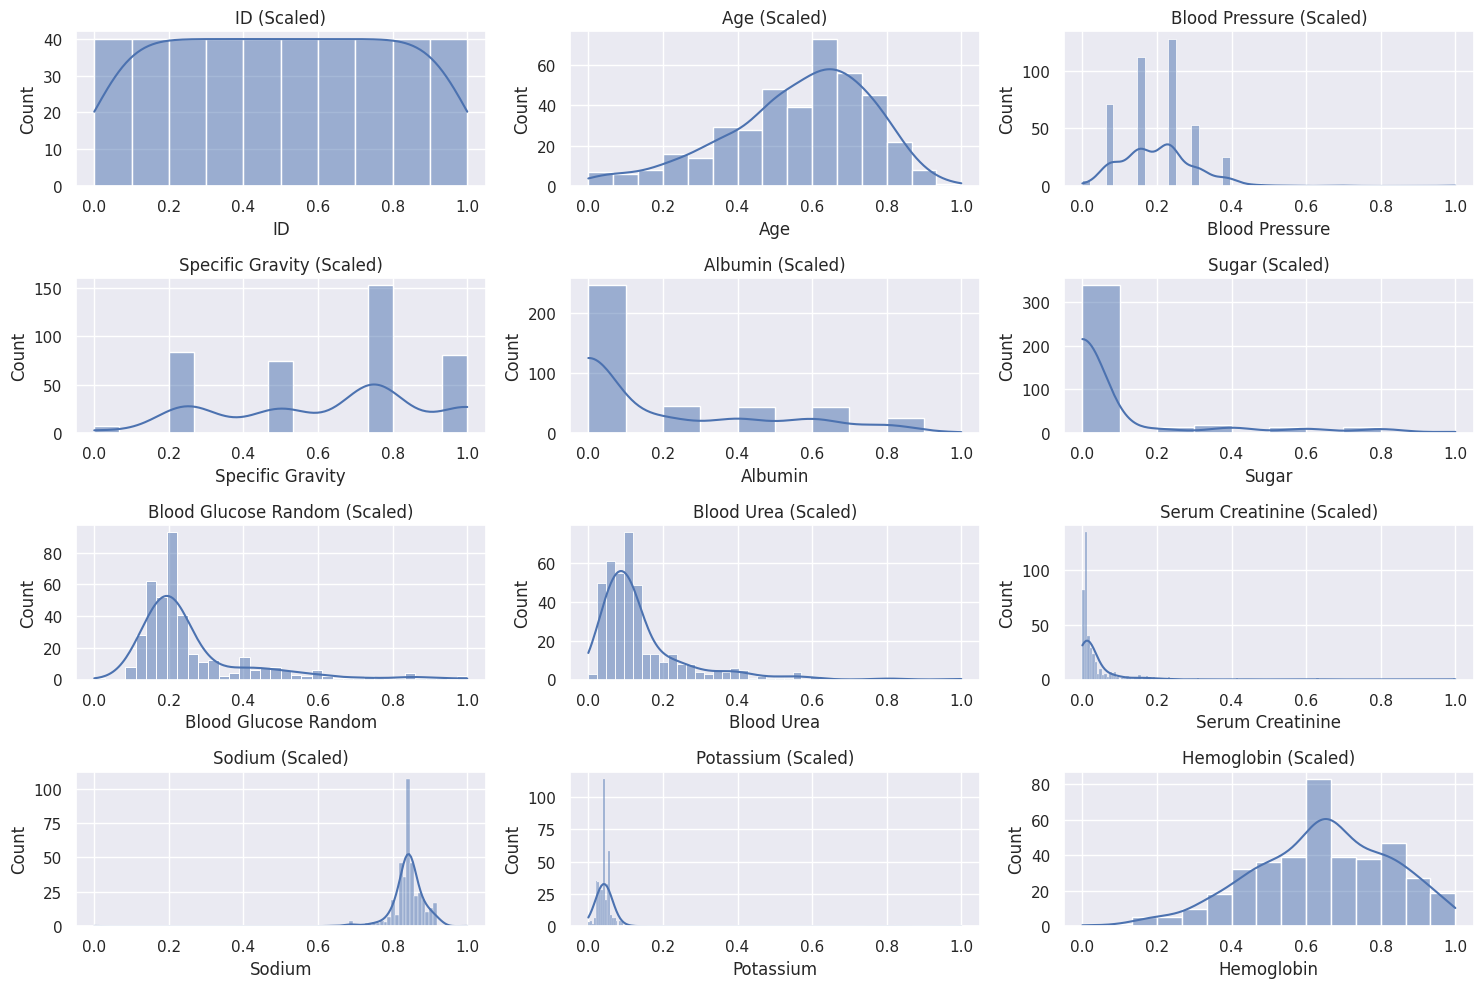

In [ ]:
# Plot histograms after scaling
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(CKD_Data[col], kde=True)
    plt.title(f'{col} (Scaled)')

plt.tight_layout()
plt.show()

## Feature Encoding
### Binary Encoding using LabelEncoder for Binary Features

## One-Hot Encoding for Multicategory Columns